In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

path = 'C:\\03FYMA\\lopputyo\\Location.csv'
speed = 'C:\\03FYMA\\lopputyo\\Linear Acceleration.csv'


df = pd.read_csv(path)
dd = pd.read_csv(speed)

print("Location")
print(df.head())
print("\nLinear acceleration")
print(dd.head())


Location
   Time (s)  Latitude (°)  Longitude (°)  Height (m)  Velocity (m/s)  \
0  0.000000     65.056581      25.473184   20.517069             NaN   
1  0.120359     65.061101      25.472537   17.815292             NaN   
2  3.092601     65.061100      25.472538    3.879978            0.37   
3  3.684197     65.061121      25.472538   11.309048            0.00   
4  4.684355     65.061123      25.472523   14.760644            0.94   

   Direction (°)  Horizontal Accuracy (m)  Vertical Accuracy (m)  
0            NaN                52.400002              10.057825  
1            NaN                25.306999               1.201034  
2     296.600006                 5.075564              10.201509  
3            NaN                 4.008297               7.068808  
4     174.199997                 4.090436               6.698652  

Linear acceleration
   Time (s)  Linear Acceleration x (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.065594                       0.451990                

Askelmäärä:  841.0


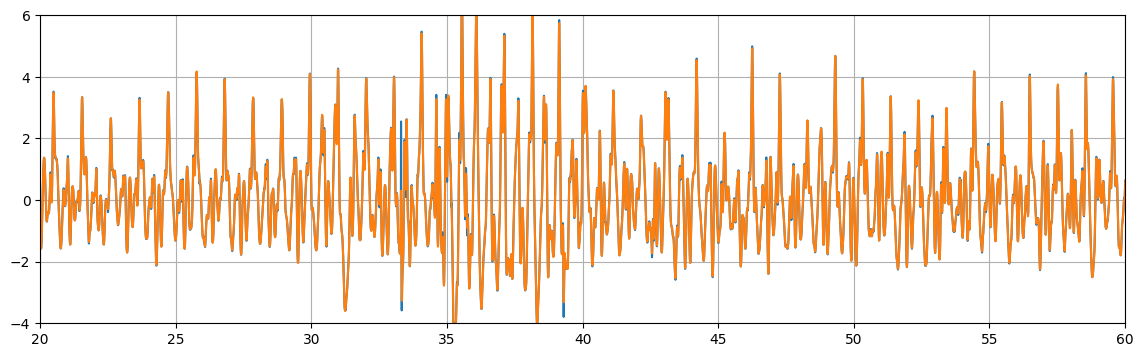

In [74]:
#Askelmäärä

#plt.subplot(3,1,1)
#plt.plot(dd['Time (s)'], dd['Linear Acceleration x (m/s^2)'])
#plt.subplot(3,1,2)
#plt.plot(dd['Time (s)'], dd['Linear Acceleration y (m/s^2)'])
#plt.subplot(3,1,3)
#plt.plot(dd['Time (s)'], dd['Linear Acceleration z (m/s^2)'])

step_comp = dd['Linear Acceleration x (m/s^2)']

from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

T = dd['Time (s)'][len(dd['Time (s)'])-1] - dd['Time (s)'][0]
n = len(dd['Time (s)'])
fs = n/T
nyq = fs/2
order = 3
cutoff = 1/(0.05)

filtered_signal = butter_lowpass_filter(step_comp, cutoff, nyq, order)
plt.figure(figsize=(14,4))
plt.plot(dd['Time (s)'], step_comp)
plt.plot(dd['Time (s)'], filtered_signal)
plt.grid()
plt.axis([20, 60, -4, 6])

#threshold = 0.08
jaksot = 0
for i in range(len(filtered_signal) -1):
    if filtered_signal[i] / filtered_signal[i+1] < 0: #and abs(filtered_signal[i]) > threshold:
        jaksot = jaksot + 1
step_count= np.floor(jaksot/2)
print('Askelmäärä: ', step_count)


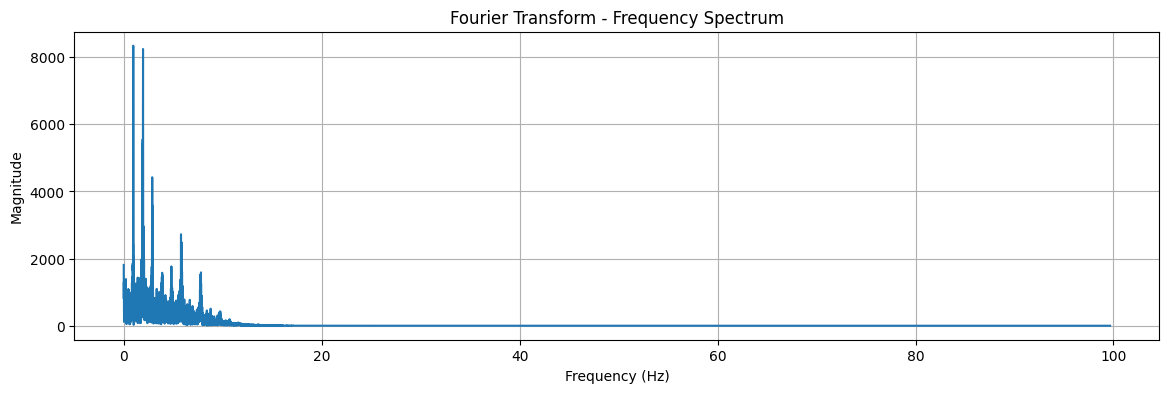

Dominant freq: 0.9645804376830013
Askelmäärä laskettuna Fourier-analyysin perusteella:  215.0


In [45]:
#Steps with fourier

from scipy.fft import fft

fft_signal = fft(filtered_signal)
fft_freq = np.fft.fftfreq(n, d=1/fs)

magnitude = np.abs(fft_signal)
plt.figure(figsize=(14, 4))
plt.plot(fft_freq[:n // 2], magnitude[:n // 2])
plt.title('Fourier Transform - Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

dominant_freq = fft_freq[np.argmax(magnitude[:n // 2])]

step_period = 1 / dominant_freq
estimated_steps = np.floor(T / step_period)

print(f'Dominant freq: {dominant_freq}')
print('Askelmäärä laskettuna Fourier-analyysin perusteella: ', estimated_steps)

In [56]:
#Average speed

print("Location Data:")

if 'Velocity (m/s)' in df.columns:
    average_speed_mps = df['Velocity (m/s)'].mean()
    average_speed_kmh = average_speed_mps * 3.6
    print(f'Average Speed: {average_speed_mps:.2f} m/s or {average_speed_kmh:.2f} km/h')
else:
    print("The 'Velocity (m/s)' column is missing in the data.")



Location Data:
Average Speed: 1.43 m/s or 5.14 km/h


In [62]:
#Total distance
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r


lat = df['Latitude (°)']
lon = df['Longitude (°)']
#df['Distance (km)'] = [haversine(lon[i], lat[i], lon[i+1], lat[i+1]) for i in range(len(lat)-1)] + [0]
df['dist'] = np.zeros(len(df))

for i in range(len(df)-1):
   df.loc[i,'dist'] = haversine(lon[i], lat[i], lon[i+1], lat[i+1])
df['tot_dist'] = np.cumsum(df['dist'])
#df.index
total_distance_km = df['tot_dist'].iloc[-1]
print(f'Total Distance Traveled: {total_distance_km:.2f} km')


Total Distance Traveled: 0.83 km


In [76]:
#Step distance

if step_count > 0:
    total_distance_m = total_distance_km * 1000
    average_step_length = total_distance_m / step_count
    print(f'Average Step Length (Askelpituus): {average_step_length:.2f} meters')
else:
    print('No steps recorded, cannot calculate average step length.')

#print(df[['Time (s)', 'Latitude (°)', 'Longitude (°)', 'dist', 'tot_dist']])

Average Step Length (Askelpituus): 0.99 meters


In [77]:
import folium

df_orig = df.copy()
df = df[df['Satellites']>14].reset_index(drop=True)
lat_mean = df['Latitude (°)'].mean()
long_mean = df['Longitude (°)'].mean()

#Kartta
m = folium.Map(location=[lat_mean, long_mean], zoom_start=14)
folium.Marker([lat_mean,long_mean]).add_to(m)
folium.PolyLine(df[['Latitude (°)', 'Longitude (°)']], color='green', opacity = 1).add_to(m)

m.save('Kartta.html')
m

KeyError: 'Satellites'